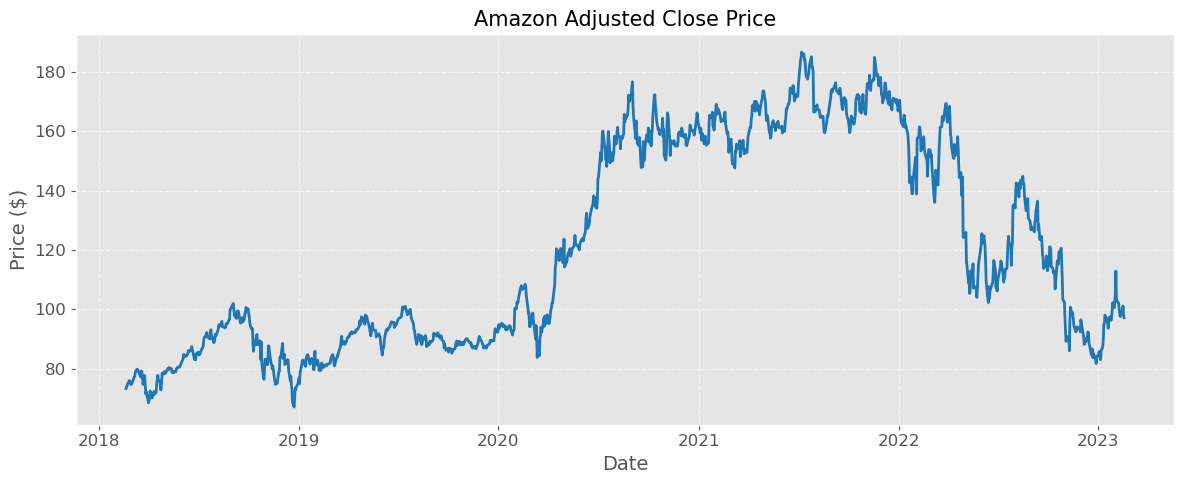

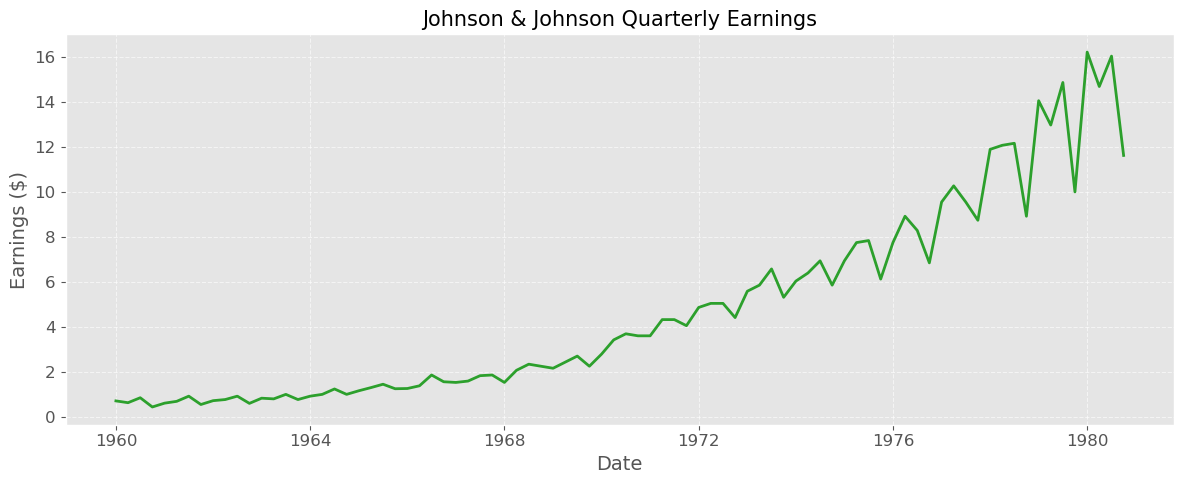


ADF Test for Amazon Raw
ADF Statistic : -1.6578
p-value       : 0.4530
Critical Value (1%) : -3.4356
Critical Value (5%) : -2.8638
Critical Value (10%) : -2.5680
Conclusion    : Not Stationary

ADF Test for JJ Raw
ADF Statistic : 2.7420
p-value       : 1.0000
Critical Value (1%) : -3.5246
Critical Value (5%) : -2.9026
Critical Value (10%) : -2.5887
Conclusion    : Not Stationary


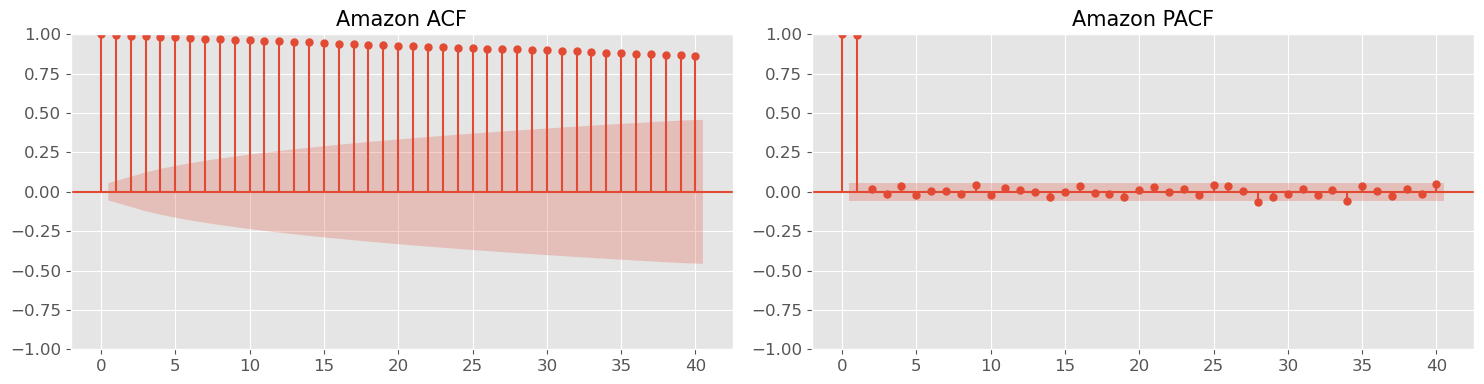

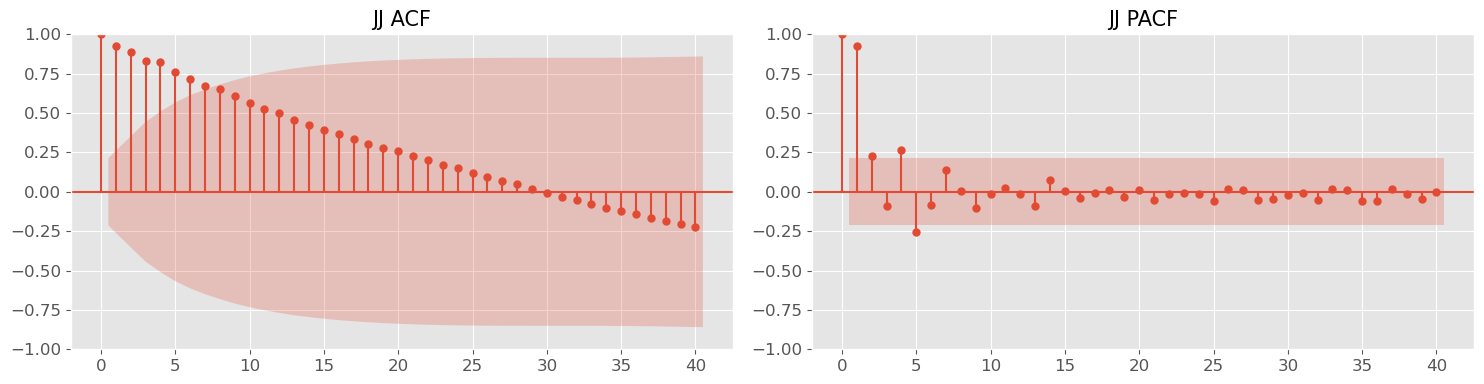


ADF Test for Amazon 1st Differenced
ADF Statistic : -36.2508
p-value       : 0.0000
Critical Value (1%) : -3.4356
Critical Value (5%) : -2.8638
Critical Value (10%) : -2.5680
Conclusion    : Stationary

ADF Test for JJ 1st + Seasonal Differenced
ADF Statistic : -4.3020
p-value       : 0.0004
Critical Value (1%) : -3.5260
Critical Value (5%) : -2.9032
Critical Value (10%) : -2.5890
Conclusion    : Stationary


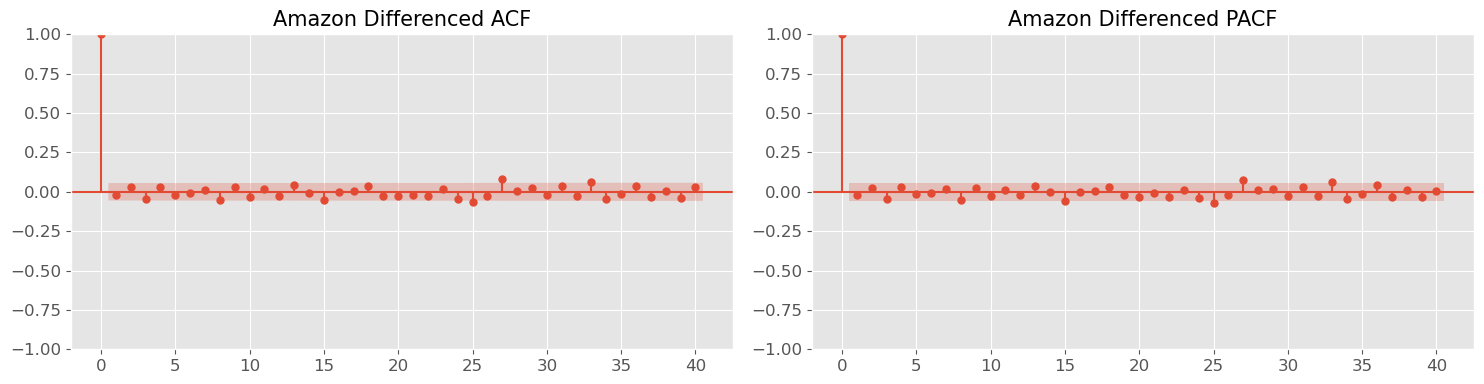

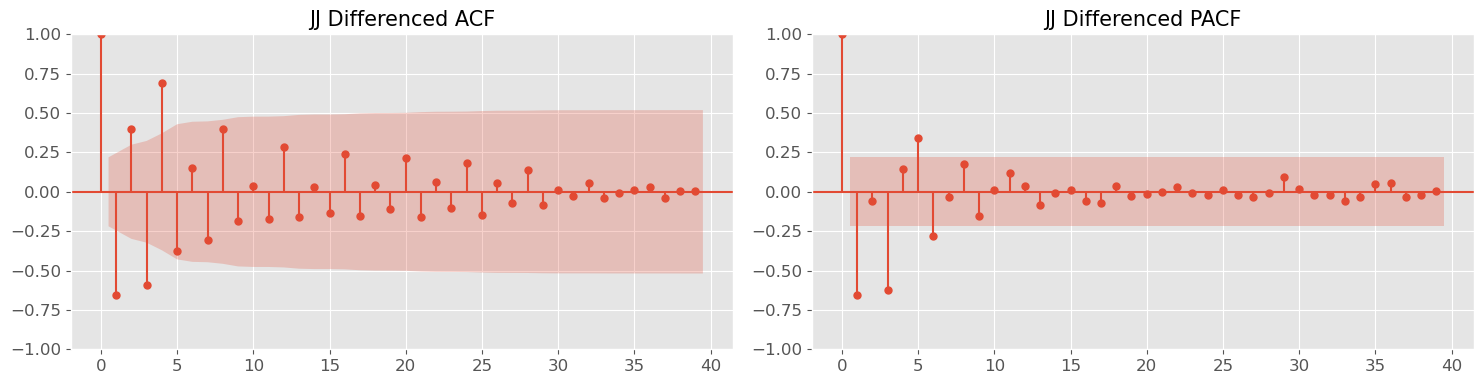


Best ARIMA model for Amazon: (1, 0, 1) (MSE: 7.4082)
Best ARIMA model for JJ: (2, 1, 2) (MSE: 3.5420)


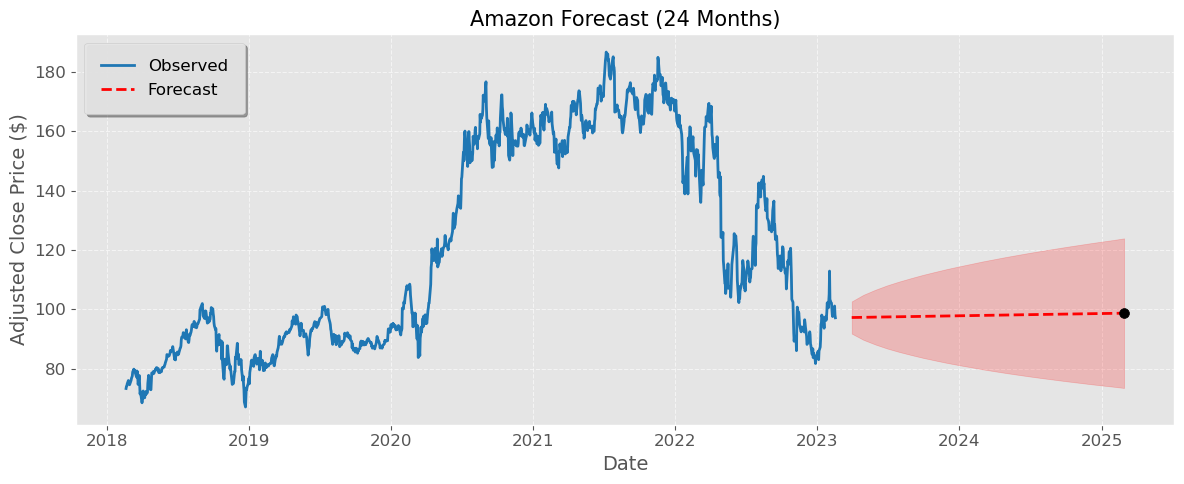

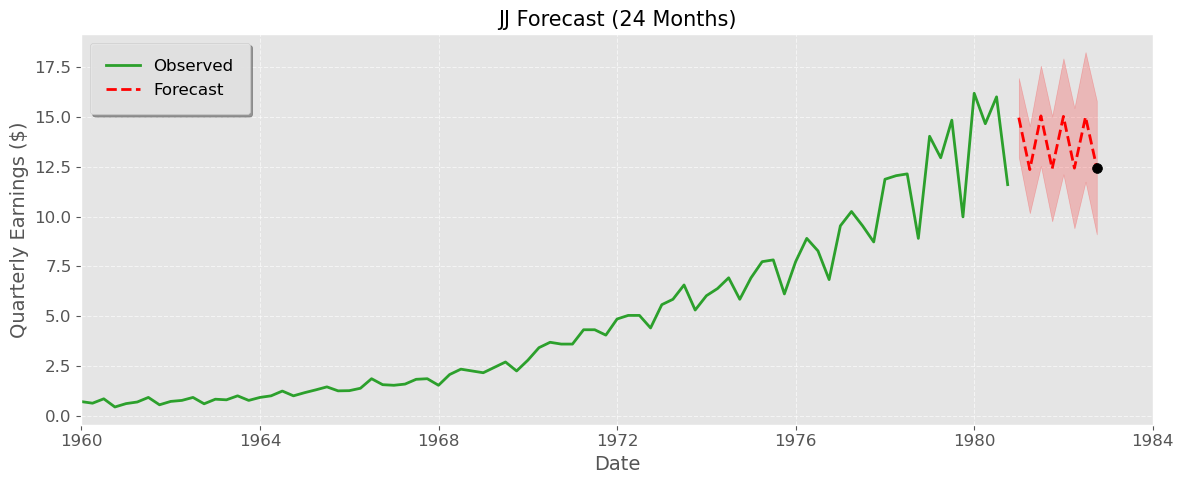

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


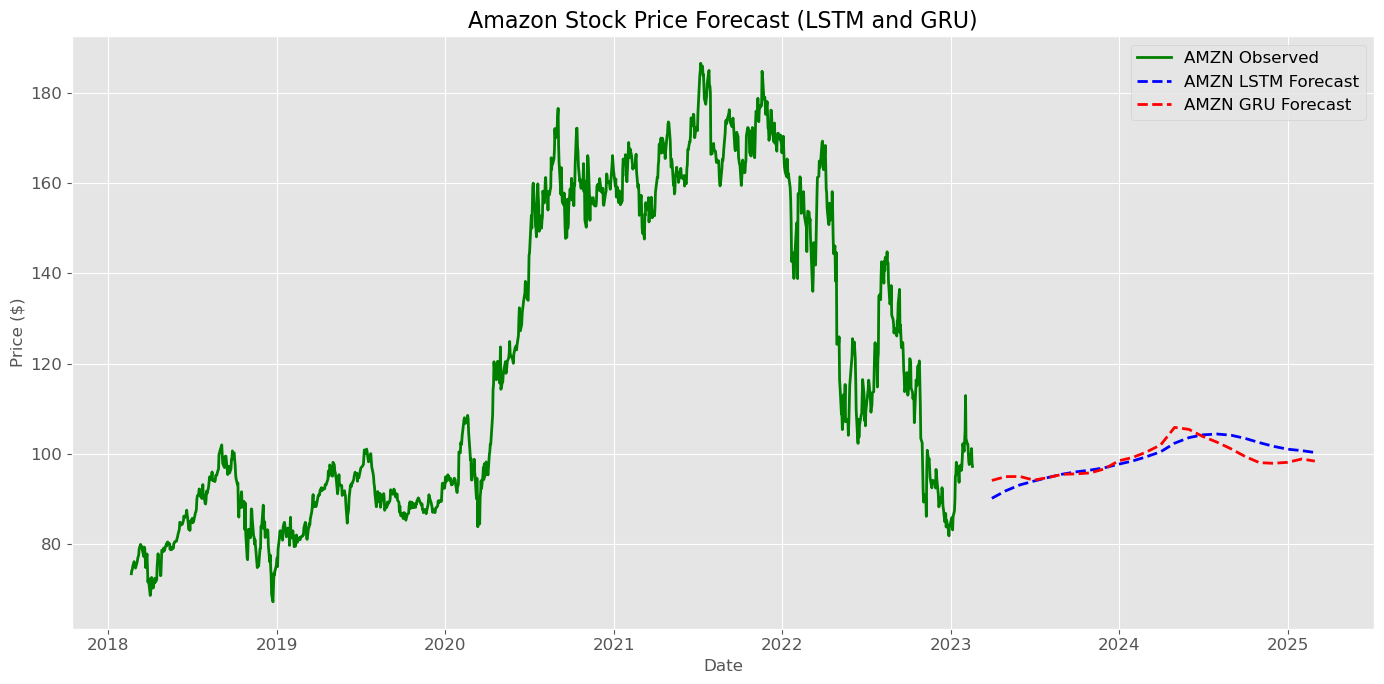

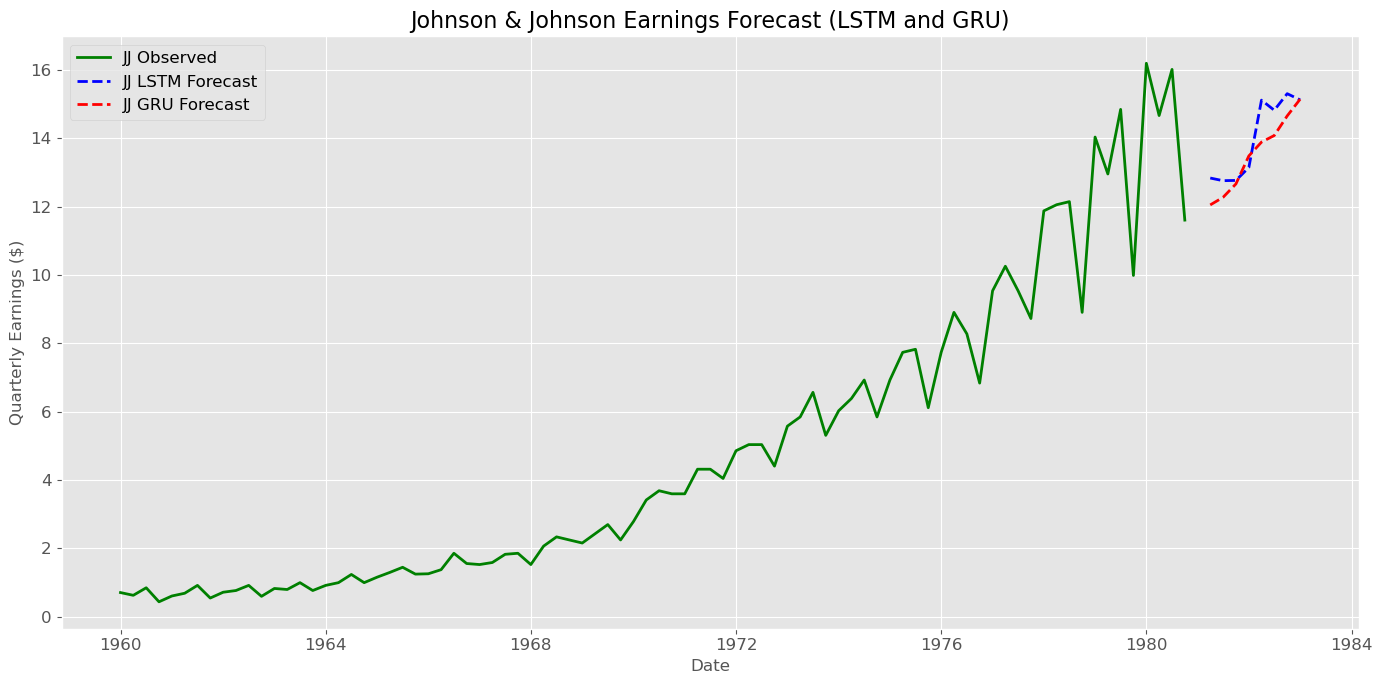

<Figure size 1200x600 with 0 Axes>

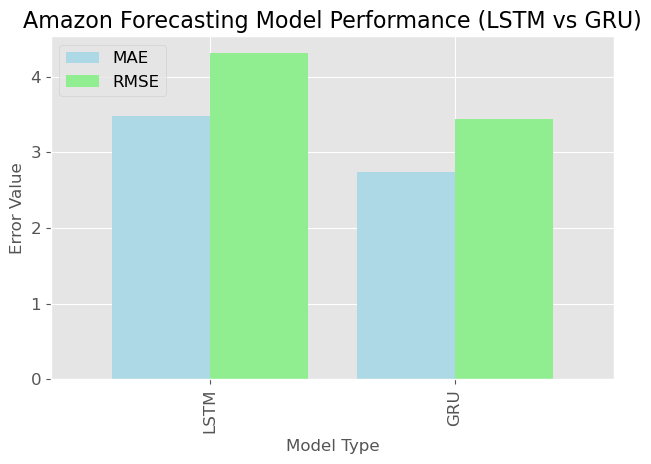

<Figure size 1200x600 with 0 Axes>

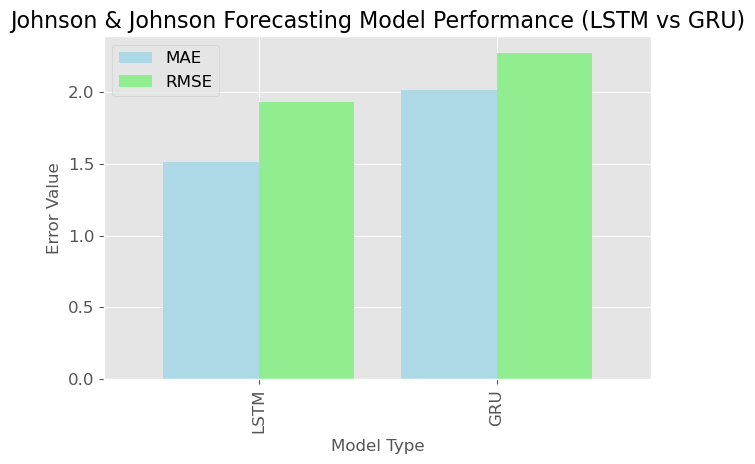

In [1]:
# Import packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import warnings

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 15})

# Load datasets
amzn_df = pd.read_csv("AMZN.csv", parse_dates=True, index_col=0)
jj_df = pd.read_csv("jj.csv", parse_dates=True, index_col=0)

# Function to plot time series data
def plot_time_series(series, title, ylabel, color):
    plt.figure(figsize=(12, 5))
    plt.plot(series, color=color, linewidth=2)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Function to test stationarity using ADF
def test_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f"\nADF Test for {title}")
    print(f"ADF Statistic : {result[0]:.4f}")
    print(f"p-value       : {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}) : {value:.4f}")
    print("Conclusion    :", "Stationary" if result[1] < 0.05 else "Not Stationary")

# Function to plot ACF and PACF
def plot_acf_pacf(series, title_prefix=""):
    series = series.dropna()
    max_lags = min(40, len(series) // 2 - 1)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(series, ax=axes[0], lags=max_lags)
    plot_pacf(series, ax=axes[1], lags=max_lags, method='ywm')
    axes[0].set_title(f"{title_prefix} ACF")
    axes[1].set_title(f"{title_prefix} PACF")
    plt.tight_layout()
    plt.show()

# Function to find the best ARIMA model
def find_best_arima_model(series, max_p=3, max_d=1, max_q=3):
    best_score, best_cfg = float("inf"), None
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=10)
                    mse = mean_squared_error(series[-10:], forecast)
                    if mse < best_score:
                        best_score, best_cfg = mse, (p, d, q)
                except:
                    continue
    return best_cfg, best_score

# Function to preprocess data for LSTM/GRU
def preprocess_data(series, steps=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = [], []
    for i in range(len(series_scaled) - steps):
        X.append(series_scaled[i:i+steps, 0])
        y.append(series_scaled[i+steps, 0])
    return np.array(X), np.array(y), scaler

# Function to create LSTM/GRU models
def create_model(input_shape, model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
    else:
        model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(GRU(units=50, return_sequences=False))
        model.add(Dropout(0.2))

    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Function to train the LSTM/GRU models
def train_model(X, y, model_type='LSTM', epochs=20, batch_size=32):
    model = create_model((X.shape[1], 1), model_type=model_type)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# Function to forecast with LSTM/GRU models
def forecast(model, X, scaler, steps=24):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Function to calculate MAE and RMSE
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return mae, rmse

# Function to plot the forecast results
def forecast_plot(series, order, steps, label, color, title, ylabel, freq, ci=False, xlim_extend=None):
    model = ARIMA(series, order=order)
    fit = model.fit()
    forecast = fit.get_forecast(steps=steps)
    pred_mean = forecast.predicted_mean
    forecast_index = pd.date_range(start=series.index[-1] + pd.DateOffset(months=1), periods=steps, freq=freq)

    ci_data = forecast.conf_int()
    lower = ci_data.iloc[:, 0].to_numpy()
    upper = ci_data.iloc[:, 1].to_numpy()

    final_point = pred_mean.iloc[-1]
    final_date = forecast_index[-1]

    plt.figure(figsize=(12, 5))
    plt.plot(series, label='Observed', color=color, linewidth=2)
    plt.plot(forecast_index, pred_mean, label='Forecast', linestyle='--', color='red', linewidth=2)
    plt.fill_between(forecast_index, lower, upper, color='red', alpha=0.2)
    plt.scatter(final_date, final_point, color='black', s=50, zorder=5)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend(loc='upper left', frameon=True, framealpha=0.95, borderpad=1, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)

    if xlim_extend:
        plt.xlim(series.index[0], xlim_extend)

    plt.tight_layout()
    plt.show()

# Plot the original data for AMAZON and JJ
plot_time_series(amzn_df['Adj Close'], "Amazon Adjusted Close Price", "Price ($)", "#1f77b4")
plot_time_series(jj_df['data'], "Johnson & Johnson Quarterly Earnings", "Earnings ($)", "#2ca02c")

# ADF and ACF/PACF tests
test_stationarity(amzn_df['Adj Close'], "Amazon Raw")
test_stationarity(jj_df['data'], "JJ Raw")
plot_acf_pacf(amzn_df['Adj Close'], "Amazon")
plot_acf_pacf(jj_df['data'], "JJ")

# Differencing
amzn_diff = amzn_df['Adj Close'].diff().dropna()
jj_diff = jj_df['data'].diff().diff(3).dropna()
test_stationarity(amzn_diff, "Amazon 1st Differenced")
test_stationarity(jj_diff, "JJ 1st + Seasonal Differenced")
plot_acf_pacf(amzn_diff, "Amazon Differenced")
plot_acf_pacf(jj_diff, "JJ Differenced")

# Grid search for the best ARIMA model
amzn_best_cfg, amzn_mse = find_best_arima_model(amzn_df['Adj Close'])
jj_best_cfg, jj_mse = find_best_arima_model(jj_df['data'])
print(f"\nBest ARIMA model for Amazon: {amzn_best_cfg} (MSE: {amzn_mse:.4f})")
print(f"Best ARIMA model for JJ: {jj_best_cfg} (MSE: {jj_mse:.4f})")

# Forecast and plot the results
forecast_plot(amzn_df['Adj Close'], order=amzn_best_cfg, steps=24, label="AMZN", color="#1f77b4",
              title="Amazon Forecast (24 Months)", ylabel="Adjusted Close Price ($)", freq='M', ci=True)

forecast_plot(jj_df['data'], order=jj_best_cfg, steps=8, label="JJ", color="#2ca02c",
              title="JJ Forecast (24 Months)", ylabel="Quarterly Earnings ($)", freq='Q',
              ci=True, xlim_extend=pd.to_datetime("1984-01-01"))

# Prepare LSTM and GRU models for AMZN and JJ (For Neural Network-based forecasting)
amzn_steps = 12
X_amzn, y_amzn, amzn_scaler = preprocess_data(amzn_df['Adj Close'], steps=amzn_steps)
X_amzn = X_amzn.reshape((X_amzn.shape[0], X_amzn.shape[1], 1))

jj_steps = 4
X_jj, y_jj, jj_scaler = preprocess_data(jj_df['data'], steps=jj_steps)
X_jj = X_jj.reshape((X_jj.shape[0], X_jj.shape[1], 1))

amzn_lstm_model = train_model(X_amzn, y_amzn, model_type='LSTM')
amzn_gru_model = train_model(X_amzn, y_amzn, model_type='GRU')
jj_lstm_model = train_model(X_jj, y_jj, model_type='LSTM')
jj_gru_model = train_model(X_jj, y_jj, model_type='GRU')

amzn_lstm_forecast = forecast(amzn_lstm_model, X_amzn[-24:], amzn_scaler, steps=24)
amzn_gru_forecast = forecast(amzn_gru_model, X_amzn[-24:], amzn_scaler, steps=24)
jj_lstm_forecast = forecast(jj_lstm_model, X_jj[-8:], jj_scaler, steps=8)
jj_gru_forecast = forecast(jj_gru_model, X_jj[-8:], jj_scaler, steps=8)

# Plot LSTM/GRU results
plt.figure(figsize=(14, 7))
plt.plot(amzn_df.index, amzn_df['Adj Close'], label='AMZN Observed', color='green', linewidth=2)
plt.plot(pd.date_range(start=amzn_df.index[-1], periods=25, freq='M')[1:], amzn_lstm_forecast, label='AMZN LSTM Forecast', linestyle='--', color='blue', linewidth=2)
plt.plot(pd.date_range(start=amzn_df.index[-1], periods=25, freq='M')[1:], amzn_gru_forecast, label='AMZN GRU Forecast', linestyle='--', color='red', linewidth=2)
plt.title('Amazon Stock Price Forecast (LSTM and GRU)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(14, 7))
plt.plot(jj_df.index, jj_df['data'], label='JJ Observed', color='green', linewidth=2)
plt.plot(pd.date_range(start=jj_df.index[-1], periods=9, freq='Q')[1:], jj_lstm_forecast, label='JJ LSTM Forecast', linestyle='--', color='blue', linewidth=2)
plt.plot(pd.date_range(start=jj_df.index[-1], periods=9, freq='Q')[1:], jj_gru_forecast, label='JJ GRU Forecast', linestyle='--', color='red', linewidth=2)
plt.title('Johnson & Johnson Earnings Forecast (LSTM and GRU)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quarterly Earnings ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Calculate Evaluation Metrics (MAE and RMSE)
amzn_lstm_mae, amzn_lstm_rmse = calculate_metrics(amzn_df['Adj Close'][-24:], amzn_lstm_forecast)
amzn_gru_mae, amzn_gru_rmse = calculate_metrics(amzn_df['Adj Close'][-24:], amzn_gru_forecast)
jj_lstm_mae, jj_lstm_rmse = calculate_metrics(jj_df['data'][-8:], jj_lstm_forecast)
jj_gru_mae, jj_gru_rmse = calculate_metrics(jj_df['data'][-8:], jj_gru_forecast)

# Plot Evaluation Metrics (MAE and RMSE)
# Evaluation Metrics Plot for LSTM and GRU (Amazon)
metrics_data_amzn = {
    'Model': ['LSTM', 'GRU'],
    'MAE': [amzn_lstm_mae, amzn_gru_mae],
    'RMSE': [amzn_lstm_rmse, amzn_gru_rmse]
}

metrics_df_amzn = pd.DataFrame(metrics_data_amzn)

plt.figure(figsize=(12, 6))
metrics_df_amzn.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar', color=['lightblue', 'lightgreen'], width=0.8)
plt.title('Amazon Forecasting Model Performance (LSTM vs GRU)', fontsize=16)
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Error Value', fontsize=12)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Evaluation Metrics Plot for LSTM and GRU (JJ)
metrics_data_jj = {
    'Model': ['LSTM', 'GRU'],
    'MAE': [jj_lstm_mae, jj_gru_mae],
    'RMSE': [jj_lstm_rmse, jj_gru_rmse]
}

metrics_df_jj = pd.DataFrame(metrics_data_jj)

plt.figure(figsize=(12, 6))
metrics_df_jj.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar', color=['lightblue', 'lightgreen'], width=0.8)
plt.title('Johnson & Johnson Forecasting Model Performance (LSTM vs GRU)', fontsize=16)
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Error Value', fontsize=12)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()